## Google Colab Setup

In [1]:
from google.colab import drive    #when not on google colab, comment out these lines
drive.mount('/content/drive')     #when not on google colab, comment out these lines

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys                                                                                     #when not on google colab, comment out these lines
sys.path.append('/content/drive/My Drive/midas/')                     #when not on google colab, comment out these lines

# This is the main notebook for Speech Emotion Recognition
This notebook is dependent on the preprocessing done by the creating_labels.ipynb and create_MFCC_dictionary.ipynb notebooks. 

## Loading Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import os
import IPython.display as ipd
from tqdm import tqdm_notebook
import seaborn as sn
import torch
import torch.nn as nn
import random as rn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch.optim as optim

SEED = 2222 
np.random.seed(SEED)
rn.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Setting up GPU
Checking if the system has GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Checking the space being used on the GPU.

In [5]:
if(str(device) == 'cuda'): print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

0.0M


## Loading the dataset
data_directory is the directory where I have stored my MFCC dictionaries.
I have used smaller subsets of the available data as y training data due to large class imbalance.

In [0]:
data_directory = '/content/drive/My Drive/midas/'

In [0]:
train = pd.read_csv('/content/drive/My Drive/midas/meld_train.csv',encoding ='utf-8')

In [0]:
val = pd.read_csv('/content/drive/My Drive/midas/meld_val.csv',encoding ='utf-8')

In [9]:
len(train),len(val)

(7345, 830)

Creating the training and validation dataset.

In [10]:
train.head()

,fname,happy,sad,disgust,fear,neutral
0,MEL_dia1000_utt0_negative_DIS.wav,0,0,1,0,0
1,MEL_dia1000_utt1_negative_DIS.wav,0,0,1,0,0
2,MEL_dia1000_utt3_neutral_NEU.wav,0,0,0,0,1
3,MEL_dia1001_utt0_neutral_NEU.wav,0,0,0,0,1
4,MEL_dia1001_utt10_positive_HAP.wav,1,0,0,0,0


In [11]:
val.head()

,fname,happy,sad,disgust,fear,neutral
0,MEL_dia0_utt10_negative_FEA.wav,0,0,0,1,0
1,MEL_dia0_utt11_neutral_NEU.wav,0,0,0,0,1
2,MEL_dia0_utt13_neutral_NEU.wav,0,0,0,0,1
3,MEL_dia0_utt2_neutral_NEU.wav,0,0,0,0,1
4,MEL_dia0_utt3_neutral_NEU.wav,0,0,0,0,1


## Choosing a small subset of the available training data, to compensate for class imbalance.

In [12]:
hap = 0
sad = 0
neu = 0
dis = 0
fea = 0
cd = pd.DataFrame() 
for i in range(len(train)):
    if(train['happy'][i] == 1 and hap < 1000):
        hap = hap + 1
        cd = pd.concat((cd,train.loc[i:i]),axis = 0)
    elif(train['sad'][i] == 1 and sad < 1000):
        sad = sad + 1
        cd = pd.concat((cd,train.loc[i:i]),axis = 0)
    elif(train['neutral'][i] == 1 and neu < 1000):
        neu = neu + 1
        cd = pd.concat((cd,train.loc[i:i]),axis = 0)
    elif(train['fear'][i] == 1 and fea < 1000):
        fea = fea + 1
        cd = pd.concat((cd,train.loc[i:i]),axis = 0)
    elif(train['disgust'][i] == 1 and dis < 1000):
        dis = dis + 1
        cd = pd.concat((cd,train.loc[i:i]),axis = 0)
cd = cd.reset_index(drop = True)
print(len(cd))

3153


Number of instances of each category.

In [13]:
hap,sad,neu,dis,fea

(1000, 705, 1000, 232, 216)

In [14]:
cd.head()

,fname,happy,sad,disgust,fear,neutral
0,MEL_dia1000_utt0_negative_DIS.wav,0,0,1,0,0
1,MEL_dia1000_utt1_negative_DIS.wav,0,0,1,0,0
2,MEL_dia1000_utt3_neutral_NEU.wav,0,0,0,0,1
3,MEL_dia1001_utt0_neutral_NEU.wav,0,0,0,0,1
4,MEL_dia1001_utt10_positive_HAP.wav,1,0,0,0,0


Creating the balanced training dataset.

In [0]:
train = cd

## Loading the .npy files and extracting the data from .npy files
These are the various files with MFCCs of each audio file stored in them. Each file has different MFCCs based on the data augmentations performed on them. 

The below cell extracts MFCCs without any augmentations. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [0]:
train_mfcc_dictionary = np.load(data_directory + 'meld_train_100_259.npy',allow_pickle=True)

In [17]:
sample_rate = 44100
dim = (100,1 + int(np.floor((sample_rate * 3)/512)))
X_train = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d = np.empty(shape=(len(train), dim[1]))

for i in tqdm_notebook(range(len(train))):
    X_train[i,] = train_mfcc_dictionary[()][str(train['fname'][i])]
    X_train_1d[i,] = np.mean(train_mfcc_dictionary[()][str(train['fname'][i])],axis = 0)

In [0]:
del train_mfcc_dictionary 
mfcc_noise_dictionary = np.load(data_directory + 'meld_train_noise_100_259.npy',allow_pickle=True)

The below cell extracts MFCCs with noise augmentaion. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [19]:
cnt = 0
X_train_noise = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d_noise = np.empty(shape=(len(train), dim[1]))
for i in tqdm_notebook(range(len(train))):
    X_train_noise[cnt,] = mfcc_noise_dictionary[()][str(train['fname'][i])]
    X_train_1d_noise[cnt,] = np.mean(mfcc_noise_dictionary[()][str(train['fname'][i])],axis = 0)
    cnt = cnt + 1

In [0]:
del mfcc_noise_dictionary 
mfcc_noise_and_shift_dictionary = np.load(data_directory + 'meld_train_noise_shift_100_259.npy',allow_pickle=True)

The below cell extracts MFCCs with noise and shifting augmentaion. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [21]:
cnt = 0
X_train_noise_and_shift = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d_train_noise_and_shift = np.empty(shape=(len(train), dim[1]))
for i in tqdm_notebook(range(len(train))):
    X_train_noise_and_shift[cnt,] = mfcc_noise_and_shift_dictionary[()][str(train['fname'][i])]
    X_train_1d_train_noise_and_shift[cnt,] = np.mean(mfcc_noise_and_shift_dictionary[()][str(train['fname'][i])],axis = 0)
    cnt = cnt + 1

In [0]:
del mfcc_noise_and_shift_dictionary 
val_mfcc_dictionary = np.load(data_directory + 'meld_val_100_259.npy',allow_pickle=True)

The below cell extracts MFCCs without any augmentaion as I don't want to increase the complexity of validation set with data augmentations. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [23]:
sample_rate = 44100
dim = (100,1 + int(np.floor((sample_rate * 3)/512)))
X_val = np.empty(shape=(len(val), dim[0], dim[1]))
X_val_1d = np.empty(shape=(len(val), dim[1]))
for i in tqdm_notebook(range(len(val))):
    X_val[i,] = val_mfcc_dictionary[()][str(val['fname'][i])]
    X_val_1d[i,] = np.mean(val_mfcc_dictionary[()][str(val['fname'][i])],axis = 0)

Deleting the mfcc dictionaries as they won't be needed any more.

In [0]:
del val_mfcc_dictionary 

In [25]:
len(X_train) ,len(X_train_noise_and_shift),len(X_train_noise)

(3153, 3153, 3153)

## Creating the training dataset
The MfCCs collected from the different .npy files is concatenated to form a proper dataset. Here, I also concatenate the means of the respective MFCCs to form another dataset.

In [0]:
X_train = np.concatenate((X_train,X_train_noise_and_shift,X_train_noise), axis=0)
X_train_1d = np.concatenate((X_train_1d,X_train_1d_train_noise_and_shift,X_train_1d_noise), axis=0)

Normalizing the dataset has shown to improve performance of the model. The cell below normalizes the MFCC values.

In [0]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_val = (X_val - mean)/std

del mean
del std

 The cell below normalizes the means of the MFCC values.

In [0]:
mean_1d = np.mean(X_train_1d, axis=0)
std_1d = np.std(X_train_1d, axis=0)

X_train_1d = (X_train_1d - mean_1d)/std_1d
X_val_1d = (X_val_1d - mean_1d)/std_1d

del mean_1d
del std_1d

Extracting the labels from the dataframe. The labels are of multi-hot encoded format.

In [0]:
y_train = train.iloc[:,1:]
y_val = val.iloc[:,1:]

In [0]:
y_train = y_train.values.tolist()
y_val = y_val.values.tolist()

The y_train is multiplied by 3 to adjust the size of the labels for the increase in the size of X_train after concatenation. Since I am not shuffling the X_train dataset and simply concatenating it, the labels perfectly align after being multiplied. Since I am not changing the size of X_val, there is no need to multiply y_val with any factor.

In [0]:
y_train = y_train*3
y_val = y_val

In [32]:
len(y_train) , len(X_train)

(9459, 9459)

## Creating Dataloaders
The data is now shifted into tensors and is then fed into a dataloader. I have used torch.utils.data.DataLoader for this task.

In [0]:
BATCH_SIZE = 300

In [0]:
X_train_tensor = torch.tensor(X_train)
X_val_tensor = torch.tensor(X_val)

In [0]:
X_train_tensor_1d = torch.tensor(X_train_1d)
X_val_tensor_1d = torch.tensor(X_val_1d)

In [0]:
y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)

In [0]:
train_dataset = TensorDataset(X_train_tensor,X_train_tensor_1d,y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

In [0]:
val_dataset = TensorDataset(X_val_tensor,X_val_tensor_1d,y_val_tensor)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

## Defining model
I tried out a bunch of different CNN, LSTM , and GRU architectures. A few of them are shown below.

In [0]:
class Convblock(nn.Module):  #for MFCC values
    def __init__(self,in_dim,out_dim,kernel,stride = 1,pool = (2,2)):
        super().__init__()
        self.conv = nn.Conv2d(in_dim,out_dim,kernel, stride=stride, padding=0)
        self.batchnorm = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pool)
        self.avgpool = nn.AvgPool2d(pool)
       
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        x = self.avgpool(x)
        return x
        

In [0]:
class Convblock1D(nn.Module): #for mean values of MFCCs
    def __init__(self,in_dim,out_dim,kernel,stride = 1,pool = 2):
        super().__init__()
        self.conv = nn.Conv1d(in_dim,out_dim,kernel, stride=stride, padding=0)
        self.batchnorm = nn.BatchNorm1d(out_dim)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(pool)
        self.avgpool = nn.AvgPool1d(pool)
       
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        x = self.avgpool(x)
        return x

In [0]:
class CNN2D_CNN1D(nn.Module):  #CNN both
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.convolution = nn.Sequential(convblock(1,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2))
        self.convolution1d = nn.Sequential(convblock1d(1,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2))
        self.dense = nn.Sequential(nn.Linear(16*4*12 + 16*12,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x,y):
        x = self.dropout(x)
        y = self.dropout(y)
        x = self.convolution(x)
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        
        y = self.convolution1d(y)
        #print(y.shape)
        y = y.view(y.shape[0],-1)
        
        z = torch.cat((x,y),dim = 1)
        z = self.dense(z)
        return z

In [0]:
class Net3(nn.Module):  #CNN 1d 2d
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.convolution = nn.Sequential(convblock(1,16,(3,5)),nn.Dropout(0.2),convblock(16,1,(3,5)),nn.Dropout(0.2))
        self.convolution1d = nn.Sequential(convblock1d(1,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2))
        self.dense = nn.Sequential(nn.Linear(128*2,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        self.gru1 = nn.GRU(61,64,batch_first = True)
        self.gru2 = nn.GRU(61,64,batch_first = True)
        self.fc1 = nn.Linear(23*64,128)
        self.fc2 = nn.Linear(16*64,128)

    def forward(self,x,y):
        x = self.convolution(x)
        x = x.squeeze(1)
        #print(x.shape)
        x, hn = self.gru1(x)
        #print(output.shape)
        y = self.convolution1d(y)
        #print(y.shape)

        y ,hn_y = self.gru2(y)
        x = x.reshape(x.shape[0],-1)
        y = y.reshape(y.shape[0],-1)
        x = self.fc1(x)
        y = self.fc2(y)
        z = torch.cat((x,y),dim = 1)
        z = self.dense(z)
        return z

In [0]:
class Net4(nn.Module):  #main model
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.convolution = nn.Sequential(convblock(1,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)))
        self.dense = nn.Sequential(nn.Linear(128,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(16*23*61,128)
        self.fc2 = nn.Linear(16*61,128)
        self.dropout = nn.Dropout(0.5)
    def forward(self,x,y):
        x = self.dropout(x)
        y = self.dropout(y)         
        x = self.convolution(x)
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)

        #z = torch.cat((x,y),dim = 1)
        z = self.dense(x)
        return z

In [0]:
class CNN2D_CNN1D_GRU(nn.Module):  #model CNN GRU
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1,16,(3,5)), nn.ReLU(),nn.Dropout(0.2),nn.AvgPool2d(10,10))
        self.pool = nn.MaxPool2d(5,5)
        self.convolution1d = nn.Sequential(convblock1d(1,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2))
        self.dense = nn.Sequential(nn.Linear( 4720,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        self.gru1 = nn.GRU(20,10,batch_first = True)
        self.gru2 = nn.GRU(16,10,batch_first = True)
        self.fc1 = nn.Linear(61*64,128)
        self.fc2 = nn.Linear(61*64,128)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x,y):
        x = self.dropout(x)
        z = self.conv(x)
        x = self.pool(x)
        x = x.squeeze(1)
        x = x.permute(0,2,1)
        x , hn = self.gru1(x)
        x = x.reshape(x.shape[0],-1)
        z = z.reshape(z.shape[0],-1)
        

        y = self.convolution1d(y)
        y = y.permute(0,2,1)
        y ,hn_y = self.gru2(y)
        y = y.reshape(y.shape[0],-1)
        a = torch.cat((x,z,y),dim = 1)
        #print(x.shape)
        #print(z.shape)
        #print(a.shape)
        #print(y.shape)
        a = self.dense(a)
        return a

In [0]:
class BiLSTM(nn.Module):  #model actual LSTM
    def __init__(self,num_labels):
        super().__init__()
        self.rnn = nn.LSTM(100,20,bidirectional = True)
        self.dense = nn.Linear(259*40,num_labels)
        self.dropout = nn.Dropout(0.1)
    def forward(self,x,y):
        x = self.dropout(x)
        x = x.squeeze(1).permute(0,2,1)
        output , (hidden,cell) = self.rnn(x)
        output = output.reshape(output.shape[0],-1)
        output = self.dense(output)
        return output

In [0]:
class BiGRU(nn.Module):  #model LSTM
    def __init__(self,num_labels):
        super().__init__()
        self.rnn = nn.GRU(100,20,bidirectional = True)
        self.dense = nn.Linear(259*40,num_labels)
        self.dropout = nn.Dropout(0.1)
    def forward(self,x,y):
        x = self.dropout(x)
        x = x.squeeze(1).permute(0,2,1)
        output , _ = self.rnn(x)
        output = output.reshape(output.shape[0],-1)
        output = self.dense(output)
        return output

In [0]:
class CNN2D(nn.Module):  #model only CNN
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.convolution = nn.Sequential(convblock(1,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2))
        self.convolution1d = nn.Sequential(convblock1d(1,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2))
        self.dense = nn.Sequential(nn.Linear(16*4*12,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x,y):
        x = self.dropout(x)
        y = self.dropout(y)
        x = self.convolution(x)
        #print(x.shape)
        x = x.view(x.shape[0],-1)

        z = self.dense(x)
        return z

In [0]:
class CNN1D(nn.Module):  #model CNN 1d
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.convolution1d = nn.Sequential(convblock1d(1,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2))
        self.dense = nn.Sequential(nn.Linear(16*12,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x,y):
        y = self.dropout(y)
        y = self.convolution1d(y)
        #print(y.shape)
        y = y.view(y.shape[0],-1)

        z = self.dense(y)
        return z

## Defining training parameters
Shifting the model to GPU if the system has the ability.

In [0]:
model = CNN1D(num_labels = 5).to(device)

Checking the space being used on the GPU.

In [205]:
if(str(device) == 'cuda'): print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

136.45056M


I have used Adam optimizer as in my experiance it works well with nn.BCEWithLogitsLoss().

In [0]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

I tried to use a variable learning rate using torch.optim.lr_scheduler.StepLR but I was unable to properly configure it for my task, hence decided to abandon it.

In [0]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

I chose nn.BCEWithLogitsLoss() as it works well with multi-hot encoded labels.

In [0]:
criterion = nn.BCEWithLogitsLoss().to(device)

Defining accuracy metrics.

In [0]:
def Accuracy(y_pred,y_true):
    y_true = y_true.cpu().detach()
    y_pred = y_pred.cpu().detach()
    correct = 0
    for i in range(len(y_pred)):
        _ ,pred_index = y_pred[i].max(0)
        _ ,true_index = y_true[i].max(0)
        if(pred_index == true_index):
            correct = correct + 1

    return correct/len(y_pred)

## Training
I have created several empty lists and dictionaries to store the progress of model's accuracy and loss characteristics. This is done to make it easy for us to observe the characteristic graphs and figure out the best configuration for our model.

In [0]:
train_losses = []
eval_losses = []
train_acc = []
val_acc = []
train_f1_acc = []
val_f1_acc = []
history_train_y_true = {}
history_train_y_pred = {}
history_val_y_true = {}
history_val_y_pred = {}

In [0]:
EPOCHS = 15

In [212]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0 #to calculate the epoch loss
    y_train_true = torch.Tensor().to(device)  #I use these tensors to calculate the epoch accuracy 
    y_train_pred = torch.Tensor().to(device)
    tqdm_dataloader = tqdm_notebook(enumerate(train_dataloader),total =(len(X_train) / BATCH_SIZE) ) #to monitor progress of the code
    for step_num,batch in tqdm_dataloader:
        audio_data,audio_data_1d,labels = tuple(t.to(device) for t in batch) #extracting batch data
        audio_data = audio_data.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
        audio_data_1d = audio_data_1d.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
        labels = labels.float()
        optimizer.zero_grad()
        logits = model(audio_data,audio_data_1d)
        y_train_true = torch.cat((y_train_true,labels), 0)  #storing batch labels
        y_train_pred = torch.cat((y_train_pred,logits), 0)  #storing batch preds
        batch_loss  = criterion(logits,labels)
        train_loss += batch_loss.item()
        tqdm_dataloader.set_description("Epoch {} train : {} {} ".format(epoch + 1,"loss:" , str(round(train_loss / (step_num + 1) , 4))))
        batch_loss.backward()
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step() 

    #recording loss and accuracy
    train_losses.append(train_loss/(step_num + 1))
    train_acc.append(Accuracy(y_train_pred,y_train_true))
    history_train_y_true[epoch] = y_train_true
    history_train_y_pred[epoch] = y_train_pred
    
    model.eval()
    eval_loss = 0        #to calculate the epoch loss
    y_val_true = torch.Tensor().to(device)   #I use these tensors to calculate the epoch accuracy 
    y_val_pred = torch.Tensor().to(device)
    tqdm_dataloader = tqdm_notebook(enumerate(val_dataloader),total =(len(X_val) / BATCH_SIZE) )  #to monitor progress of the code
    with torch.no_grad():
        for step_num,batch in tqdm_dataloader:
            audio_data,audio_data_1d,labels = tuple(t.to(device) for t in batch)  #extracting batch data
            audio_data = audio_data.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
            audio_data_1d = audio_data_1d.unsqueeze(1).float() #using unsqueeze to match the input dimensions to those needed by the model
            labels = labels.float()
            logits = model(audio_data,audio_data_1d)
            y_val_true = torch.cat((y_val_true,labels), 0)  #storing batch labels
            y_val_pred = torch.cat((y_val_pred,logits), 0)  #storing batch preds
            batch_loss  = criterion(logits,labels)
            eval_loss += batch_loss.item()
            tqdm_dataloader.set_description("Epoch {} val : {} {} ".format(epoch + 1,"loss:" , str(round(eval_loss / (step_num + 1) , 4))))
    
    #recording loss and accuracy
    eval_losses.append(eval_loss/(step_num + 1))
    val_acc.append(Accuracy(y_val_pred,y_val_true))  
    history_val_y_true[epoch] = y_val_true
    history_val_y_pred[epoch] = y_val_pred
    #scheduler.step() #(not used in this code)

    if(eval_loss/(step_num + 1) == min(eval_losses) ):
        torch.save(model.state_dict(), '/content/drive/My Drive/midas/model_CNN_1d.pth')  #save the best model
        print("saved")


saved



saved



saved



saved



saved



saved


## Observations

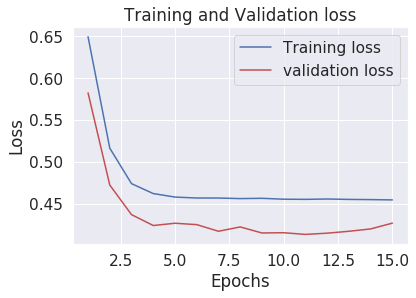

In [200]:
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, eval_losses, 'r', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

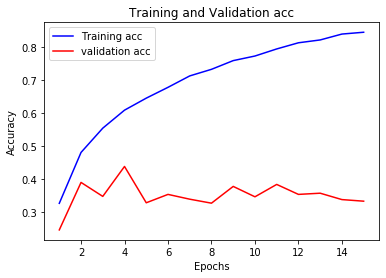

In [61]:
epochs = range(1, EPOCHS + 1  )
plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Checking the best performing model parameters.

In [213]:
model_for_eval = model
model_for_eval.load_state_dict(torch.load('/content/drive/My Drive/midas/model_CNN_1d.pth'))
model_for_eval.eval()
y_val_true = torch.Tensor().to(device)   #I use these tensors to calculate the epoch accuracy 
y_val_pred = torch.Tensor().to(device)
tqdm_dataloader = tqdm_notebook(enumerate(val_dataloader),total =(len(X_val) / BATCH_SIZE) )
with torch.no_grad():
        for step_num,batch in tqdm_dataloader:
            audio_data,audio_data_1d,labels = tuple(t.to(device) for t in batch)  #extracting batch data
            audio_data = audio_data.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
            audio_data_1d = audio_data_1d.unsqueeze(1).float() #using unsqueeze to match the input dimensions to those needed by the model
            labels = labels.float()
            logits = model_for_eval(audio_data,audio_data_1d)
            y_val_true = torch.cat((y_val_true,labels), 0)  #storing batch labels
            y_val_pred = torch.cat((y_val_pred,logits), 0)  #storing batch preds
            batch_loss  = criterion(logits,labels)
            eval_loss += batch_loss.item()
            tqdm_dataloader.set_description("Epoch {} val : {} {} ".format(epoch + 1,"loss:" , str(round(eval_loss / (step_num + 1) , 4))))
print(Accuracy(y_val_pred,y_val_true)*100)


56.024096385542165


In [0]:
def confusion_matrix_val(y_pred,y_true): 
    matrix = np.zeros((y_true.shape[1],y_true.shape[1]))
    y_true = y_true.cpu().detach()
    y_pred = y_pred.cpu().detach()
    for i in range(len(y_pred)):
        _ ,pred_index = y_pred[i].max(0)
        _ ,true_index = y_true[i].max(0)
        matrix[true_index][pred_index] = matrix[true_index][pred_index] + 1
    df_cm = pd.DataFrame(matrix, index = [i for i in ['happy','sad','disgust','fear','neutral']],columns = [i for i in ['happy','sad','disgust','fear','neutral']])
    plt.figure(figsize = (11,7))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues",annot=True)

Observing the confusion matrix.

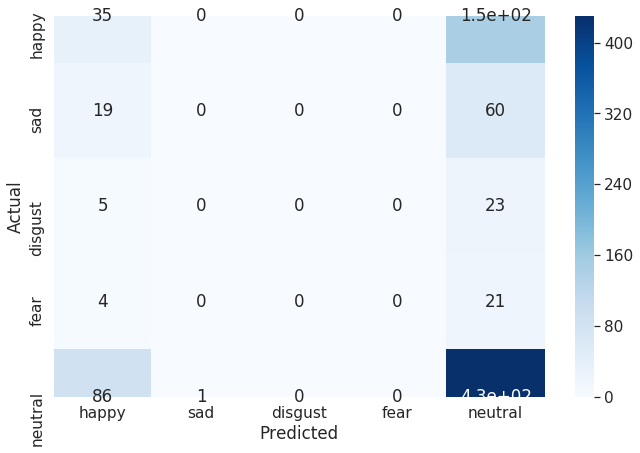

In [215]:
confusion_matrix_val(y_val_pred,y_val_true)